# RSA on MEG data with MNE python

This notebook demonstrates how to compute RDM movies from temporal data in MNE and identify significant temporal clusters of data-model RDM correlations.

### Steps:

1) load MNE epoched data (```mne.epochs.Epochs```)

    a) loading, downsampling, epoching, equalizing event count    
    b) simulate multiple subjects from single subject
    
2) import epoched data into rsatoolbox (```mne.epochs.Epochs```  $\rightarrow$ ```rsatoolbox.data.TemporalDataset```)
3) compute RDM movie (```rsatoolbox.data.TemporalDataset``` $\rightarrow$ ```rsatoolbox.rdm.rdms.RDMs```)
4) evaluate RDM movie similarity to model RDMs (```rsatoolbox.rdm.rdms.RDMs``` $\rightarrow$ ```rsatoolbox.inference.result.Result```)
5) compute cluster-based permutation statistic (```rsatoolbox.inference.result.Result``` $-\text{mne.stats.permutation\_cluster\_1samp\_test}\rightarrow$ inference results)


In [2]:
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt

import mne
from mne.io import read_raw_fif, concatenate_raws
from mne.datasets import visual_92_categories

import sys
sys.path.append('..')
import rsatoolbox

## 1) load MNE epoched data

This step follows the first steps of [https://mne.tools/dev/auto_examples/decoding/decoding_rsa_sgskip.html#sphx-glr-auto-examples-decoding-decoding-rsa-sgskip-py](https://mne.tools/dev/auto_examples/decoding/decoding_rsa_sgskip.html#sphx-glr-auto-examples-decoding-decoding-rsa-sgskip-py)

### 1a) loading, downsampling, epoching, equalizing event count

In [223]:
data_path = visual_92_categories.data_path()

In [344]:
# Define stimulus - trigger mapping
fname = data_path / 'visual_stimuli.csv'
conds = read_csv(fname)

max_trigger = 93 # 93 all events, can be set lower number to reduce computation time
conds = conds[:max_trigger]  # take only the first max_trigger rows

conditions = []
for c in conds.values:
    cond_tags = list(c[:2])
    cond_tags += [('not-' if i == 0 else '') + conds.columns[k]
                  for k, i in enumerate(c[2:], 2)]
    conditions.append('/'.join(map(str, cond_tags)))

print('condiiton names')
print(f'{str(conditions[:3])[:-1]}, \n... ,\n{str(conditions[-3:])[1:]}')

event_id = dict(zip(conditions, conds.trigger + 1))

condiiton names
['0/human bodypart/human/not-face/animal/natural', '1/human bodypart/human/not-face/animal/natural', '2/human bodypart/human/not-face/animal/natural', 
... ,
'89/artificial inanimate/not-human/not-face/not-animal/not-natural', '90/artificial inanimate/not-human/not-face/not-animal/not-natural', '91/artificial inanimate/not-human/not-face/not-animal/not-natural']


In [230]:
n_runs = 4  # 4 for full data (use less to speed up computations)
fnames = [data_path / f'sample_subject_{b}_tsss_mc.fif' for b in range(n_runs)]
raws = [read_raw_fif(fname, verbose='error', on_split_missing='ignore')
        for fname in fnames]  # ignore filename warnings
raw = concatenate_raws(raws, preload=True)

# downsample data to ~ 100Hz
current_sfreq = raw.info['sfreq']
desired_sfreq = 200  # Hz
decim = np.round(current_sfreq / desired_sfreq).astype(int)
obtained_sfreq = current_sfreq / decim
lowpass_freq = obtained_sfreq / 3.

raw_filtered = raw.copy().filter(l_freq=None, h_freq=lowpass_freq)

# create epoched data 
events = mne.find_events(raw, min_duration=.002)
events = events[events[:, 2] <= max_trigger]
picks = mne.pick_types(raw.info, meg=True)
epochs = mne.Epochs(raw, events=events, event_id=event_id, baseline=None,
                    picks=picks, tmin=-.1, tmax=.500, preload=True,
                    decim=decim)

Filtering raw data in 4 contiguous segments
Setting up low-pass filter at 67 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 66.67 Hz
- Upper transition bandwidth: 16.67 Hz (-6 dB cutoff frequency: 75.00 Hz)
- Filter length: 199 samples (0.199 sec)

4142 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93 200 222 244]
Not setting metadata
2760 matching events found
No baseline correction applied
0 projection items activated
Using data from 

C:\Users\bepet\AppData\Local\Temp\ipykernel_23300\1576110061.py:20: RuntimeWarning: The measurement information indicates a low-pass frequency of 330 Hz. The decim=5 parameter will result in a sampling frequency of 200 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events=events, event_id=event_id, baseline=None,


2 bad epochs dropped


No projector specified for this dataset. Please consider the method self.add_proj.


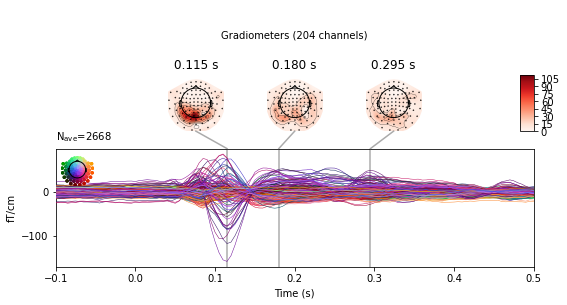

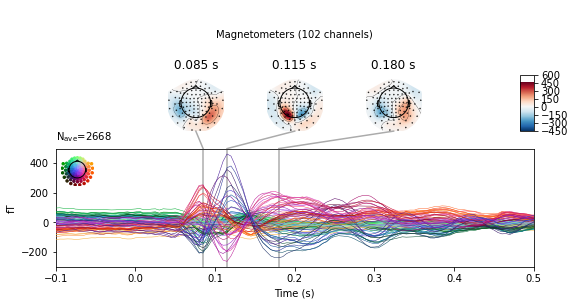

[<Figure size 576x302.4 with 7 Axes>, <Figure size 576x302.4 with 7 Axes>]

In [345]:
epochs.average().plot_joint()

We need to equalize event count in order to make use of the default crossvalidation scheme in rsatoolbox for the crossnobis calculations. Alternatively, we could also devise another crossvalidation scheme for which we might choose not to equalize event count.

In [232]:
epochs.equalize_event_counts()

Dropped 90 epochs: 930, 1478, 1479, 1480, 1481, 1482, 1486, 1492, 1493, 1499, 1504, 1505, 1518, 1520, 1521, 1525, 1539, 1657, 1659, 1669, 1709, 1713, 1730, 1742, 1743, 1745, 1749, 1752, 1754, 1757, 1758, 1761, 1763, 1768, 1770, 1771, 1772, 1774, 1777, 1778, 1779, 1780, 1781, 1782, 1784, 1785, 1787, 1788, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1798, 1800, 1803, 1805, 1806, 1807, 1808, 1810, 1812, 1814, 1815, 1817, 1818, 1819, 1820, 1821, 1823, 1824, 1825, 1826, 1827, 1830, 1831, 1832, 1833, 1836, 1837, 1838, 1946, 1959, 2001, 2007, 2011, 2013, 2016


(<Epochs |  2668 events (all good), -0.1 - 0.5 sec, baseline off, ~760.1 MB, data loaded,
  '0/human bodypart/human/not-face/animal/natural': 29
  '1/human bodypart/human/not-face/animal/natural': 29
  '2/human bodypart/human/not-face/animal/natural': 29
  '3/human bodypart/human/not-face/animal/natural': 29
  '4/human bodypart/human/not-face/animal/natural': 29
  '5/human bodypart/human/not-face/animal/natural': 29
  '6/human bodypart/human/not-face/animal/natural': 29
  '7/human bodypart/human/not-face/animal/natural': 29
  '8/human bodypart/human/not-face/animal/natural': 29
  '9/human bodypart/human/not-face/animal/natural': 29
  and 82 more events ...>,
 array([1823, 1493, 1713, 1780, 1774, 1768, 1832, 1742, 1777, 1521,  930,
        1492, 1525, 1795, 1758, 1657, 1791, 1831, 1810, 1819, 1808, 1730,
        1803, 1763, 2007, 1821, 1479, 1520, 1778, 1782, 1504, 1781, 1787,
        1824, 1499, 2011, 1478, 1793, 1820, 1784, 1798, 2013, 1757, 1749,
        1827, 1669, 1814, 1743, 1745,

In [233]:
# only using magnetometers for this example
picks = ['mag']

# dimension labels
ch_names = [ch_name for ch_name, ch_type in zip(epochs.ch_names, epochs.get_channel_types()) if ch_type in picks]
event_ids = epochs.event_id
times = epochs.times

n_events, n_channels, n_times = epochs.get_data(picks=picks).shape

### 1b) simulate multiple subjects

We will simulate multiple subjects as noisy versions of the one subject

1) We will first compute the noise precision matrix and the condition averages for one subject
2) We then create simulated subjects

#### compute channel noise precision matrix for single subject

compute residuals by subtracting repition-averaged timecourses

In [350]:
residuals = np.zeros_like(epochs.get_data(picks=picks))

# loop over event_id and compute residuals
for event_id, trigger in epochs.event_id.items():
    events_data = epochs[event_id].get_data(picks=picks) # n_repetitions x n_channels x n_times    
    residuals[event_id == event_names, :, :] = events_data - np.mean(events_data, axis=0, keepdims=True)

print(f'{residuals.shape=} = (n_events, n_channels, n_timepoints)')

residuals.shape=(2668, 102, 121) = (n_events, n_channels, n_timepoints)


compute precision matrix - we collapse timepoints and events into one dimension

In [235]:
reshaped_residuals = np.swapaxes(residuals, 1, 2).reshape(-1, n_channels)
print(f'{reshaped_residuals.shape=} = (n_events * n_timepoints, n_channels)')

prec = rsatoolbox.data.prec_from_residuals(reshaped_residuals, method='shrinkage_diag')
print(f'{prec.shape=} = (n_channels, n_channels)')

reshaped_residuals.shape=(322828, 102) = (n_events * n_timepoints, n_channels)
prec.shape=(102, 102) = (n_channels, n_channels)


#### compute condition averages for single subject

In [277]:
averaged_epochs = np.zeros((len(epochs.event_id), n_channels, len(epochs.times)))

for ii,(event_id, trigger) in enumerate(epochs.event_id.items()):
    averaged_epochs[ii, :, :] = epochs[event_id].average().get_data(picks=picks)

print(f'{averaged_epochs.shape=} = (n_conditions, n_channels, n_timepoints)')

averaged_epochs.shape=(92, 102, 121) = (n_conditions, n_channels, n_timepoints)


#### simulate multiple subjects

In [237]:
n_subjects = 7
noise = .1 # as multiple of np.std(averaged_epochs)

In [351]:
data_sd = averaged_epochs.std()
group_data = [epochs.get_data(picks=picks) + np.random.randn(*epochs.get_data(picks=picks).shape) * noise * data_sd for _ in range(n_subjects)]
print(f'{len(group_data)=} = (n_subjects) each element is a {group_data[0].shape=} = (n_conditions, n_channels, n_timepoints)')

# we'll just use the same precision noise matrix for all subjects for this example
group_prec_matrix = [prec] * n_subjects
print(f'\n{len(group_prec_matrix)=} = (n_subjects), each element is a {group_prec_matrix[0].shape=} = (n_channels, n_channels) matrix')

len(group_data)=7 = (n_subjects) each element is a group_data[0].shape=(2668, 102, 121) = (n_conditions, n_channels, n_timepoints)

len(group_prec_matrix)=7 = (n_subjects), each element is a group_prec_matrix[0].shape=(102, 102) = (n_channels, n_channels) matrix


## 2) import data into rsa toolbox

We import the events (not the averaged epochs) into the RSA toolbox here. This is because we compute the crossvalidated mahalanobis distance which requires crossvalidation.

In [354]:
# get condition name per event and parse the factor levels
rev_event_id = {v: k for k, v in epochs.event_id.items()}
event_names = np.array([rev_event_id[i] for i in epochs.events[:, 2]])

image_index = np.array([int(event_name.split('/')[0]) for event_name in event_names])
condition = np.array([event_name.split('/')[1] for event_name in event_names])
human = np.array([event_name.split('/')[2] for event_name in event_names])
face = np.array([event_name.split('/')[3] for event_name in event_names])
animal = np.array([event_name.split('/')[4] for event_name in event_names])
natural = np.array([event_name.split('/')[5] for event_name in event_names])

In [240]:
des = {'session': 0}                        # some (made up) metadata, we could also append data session-wise and crossvalidate across sessions ...
                                            # ... but we'll just pretend all data came from one session and crossvalidate across image category repetitions

obs_des = dict(                             # observation descriptors
                image_index=image_index,    # image index
                condition=condition,        # image category
                human=human,                # human vs not-human
                face=face,                  # face vs not-face
                animal=animal,              # animal vs not-animal
                natural=natural             # natural vs not-natural
                )

chn_des = {'channels': ch_names}            # channel descriptors

tim_des = {'time': times}                   # time descriptor


data = []
for i, subject_data in enumerate(group_data):
    des['subject'] = i
    data.append(rsatoolbox.data.TemporalDataset(subject_data,
                                descriptors = des,
                                obs_descriptors = obs_des,
                                channel_descriptors = chn_des,
                                time_descriptors = tim_des))
    data[-1].sort_by('image_index')

## 3) compute RDM movie

In [241]:
descriptor = 'image_index'
rdms_data = rsatoolbox.rdm.calc_rdm_movie(
                           data, # list of length n_subjects
                           method = 'crossnobis',
                           descriptor = descriptor,
                           noise = group_prec_matrix # list of len(data)
                           )
print(rdms_data.dissimilarities.shape)
print(f'{rdms_data.dissimilarities.shape=} = (n_subjects * n_timepoints, n_conditions * (n_conditions-1) / 2)')

(847, 4186)
rdms_data.dissimilarities.shape=(847, 4186) = (n_subjects * n_timepoints, n_conditions * (n_conditions-1) / 2)


In [546]:
from typing import List, Optional
from scipy.spatial.distance import squareform


def plot_rdm_movie(rdms_data: rsatoolbox.rdm.RDMs, 
                   descriptor: str, 
                   n_t_display:int = 20, # 
                   fig_width: Optional[int] = None, 
                   timecourse_plot_rel_height: Optional[int] = None,  
                   time_formatted: Optional[List[str]] = None,
                   colored_conditions: Optional[list] = None,
                   plot_individual_dissimilarities: Optional[bool] = None,
                   ): 
    """ plots the RDM movie for a given descriptor

    Args:
        rdms_data (rsatoolbox.rdm.RDMs): rdm movie
        descriptor (str): name of the descriptor that created the rdm movie
        n_t_display (int, optional): number of RDM time points to display. Defaults to 20.
        fig_width (int, optional):  width of the figure (in inches). Defaults to None.
        timecourse_plot_rel_height (int, optional): height of the timecourse plot (relative to the rdm movie row).
        time_formatted (List[str], optional): time points formatted as strings. 
            Defaults to None (i.e., rdms_data.time_descriptors['time'] is considered to be in seconds)
        colored_condiitons (list, optional): vector of pattern condition names to dissimilarities according to a categorical model on colored_conditions Defaults to None.
        plot_individual_dissimilarities (bool, optional): whether to plot the individual dissimilarities. Defaults to None (i.e., False if colored_conditions is notNone, True otherwise).

    Returns:
        Tuple[matplotlib.figure.Figure, npt.ArrayLike, collections.defaultdict]:
        
        Tuple of
            - Handle to created figure
            - Subplot axis handles from plt.subplots.
    """
    # create labels
    time = rdms_data.rdm_descriptors['time']
    unique_time = np.unique(time)
    time_formatted = time_formatted or ['%0.0f ms' % (np.round(x*1000,2)) for x in unique_time]
   
    n_dissimilarity_elements = rdms_data.dissimilarities.shape[1]    
    
    # color mapping from colored conditions
    unsquareform = lambda a: a[np.nonzero(np.triu(a, k=1))]
    if colored_conditions is not None:  
        plot_individual_dissimilarities = False if plot_individual_dissimilarities is None else plot_individual_dissimilarities
        unsquare_idx = np.triu_indices(n_dissimilarity_elements, k=1)        
        pairwise_conds = unsquareform(np.array([[{c1, c2} for c1 in colored_conditions] for c2 in colored_conditions]))
        pairwise_conds_unique = np.unique(pairwise_conds)
        cnames = np.unique(colored_conditions)
        color_index = {f'{list(x)[0]} vs {list(x)[1]}' if len(list(x))==2 else f'{list(x)[0]} vs {list(x)[0]}': pairwise_conds==x for x in pairwise_conds_unique}        
    else:
        color_index = {'': np.array([True]*n_dissimilarity_elements)}
        plot_individual_dissimilarities = True
    
    colors = plt.get_cmap('turbo')(np.linspace(0, 1, len(color_index)+1))
           
    # how many rdms to display
    t_display_idx = (np.round(np.linspace(0, len(unique_time)-1, min(len(unique_time), n_t_display)))).astype(int)
    t_display_idx = np.unique(t_display_idx)
    n_t_display = len(t_display_idx)
    
    # auto determine relative sizes of axis
    timecourse_plot_rel_height = timecourse_plot_rel_height or n_t_display // 3
    base_size = 40 / n_t_display if fig_width is None else fig_width / n_t_display   
    
    # figure layout
    fig = plt.figure(constrained_layout=True, figsize=(base_size*n_t_display,base_size*timecourse_plot_rel_height))
    gs = fig.add_gridspec(timecourse_plot_rel_height+1, n_t_display)
    tc_ax = fig.add_subplot(gs[:-1,:])
    rdm_axes = [fig.add_subplot(gs[-1,i]) for i in range(n_t_display)]

    # plot dissimilarity timecourses
    lines = []        
    
    dissimilarities_mean = np.zeros((rdms_data.dissimilarities.shape[1], len(unique_time)))
    dissimilarities_sem = np.zeros((rdms_data.dissimilarities.shape[1], len(unique_time))) 
        
    for i, t in enumerate(unique_time):
        dissimilarities_mean[:, i] = np.mean(rdms_data.dissimilarities[t == time, :], axis=0)
    
    def _plot_mean_dissimilarities(labels=False):        
        for i, (pairwise_name, idx) in enumerate(color_index.items()):
            mn = np.mean(dissimilarities_mean[idx, :],axis=0)
            se = np.std(dissimilarities_mean[idx, :],axis=0)/ np.sqrt(dissimilarities_mean.shape[0]) # se is over dissimilarities, not over subjects
            tc_ax.fill_between(unique_time, mn-se, mn+se, color=colors[i], alpha=.3)
            tc_ax.plot(unique_time, mn, color=colors[i], linewidth=2, label=pairwise_name if labels else None)
        
    def _plot_individual_dissimilarities():
        for i, (pairwise_name, idx) in enumerate(color_index.items()):
            tc_ax.plot(unique_time, dissimilarities_mean[idx, :].T, color=colors[i], alpha=max(1/255., 1/n_dissimilarity_elements))
    
    if plot_individual_dissimilarities:
        if colored_conditions is not None:
            _plot_mean_dissimilarities()
            yl = tc_ax.get_ylim()
            _plot_individual_dissimilarities()
            tc_ax.set_ylim(yl)
        else:
            _plot_individual_dissimilarities()
    
    if colored_conditions is not None:
        _plot_mean_dissimilarities(True)
    
    yl = tc_ax.get_ylim()
    for t in unique_time[t_display_idx]:
        tc_ax.plot([t,t], yl, linestyle=':', color='b', alpha=0.3)
    tc_ax.set_ylabel(f'Dissimilarity\n({rdms_data.dissimilarity_measure})')
    tc_ax.set_xticks(unique_time)
    tc_ax.set_xticklabels([time_formatted[idx]  if idx in t_display_idx else '' for idx in range(len(unique_time))])
    dt = np.diff(unique_time[t_display_idx])[0]
    tc_ax.set_xlim(unique_time[t_display_idx[0]]-dt/2, unique_time[t_display_idx[-1]]+dt/2)

    tc_ax.legend()
    
    # display (selected) rdms
    vmax = np.std(rdms_data.dissimilarities) * 2
    for i, (tidx, a) in enumerate(zip(t_display_idx, rdm_axes)):        
        a.imshow(np.mean(rdms_data.subset('time', times[tidx]).get_matrices(),axis=0), vmin=0, vmax=vmax);
        a.set_title('%0.0f ms' % (np.round(unique_time[tidx]*1000,2)))
        a.set_yticklabels([])
        a.set_yticks([])    
        a.set_xticklabels([])
        a.set_xticks([])    
            
    return fig, [tc_ax] + rdm_axes

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'data RDM movie and individual dissimilarity trajectories')

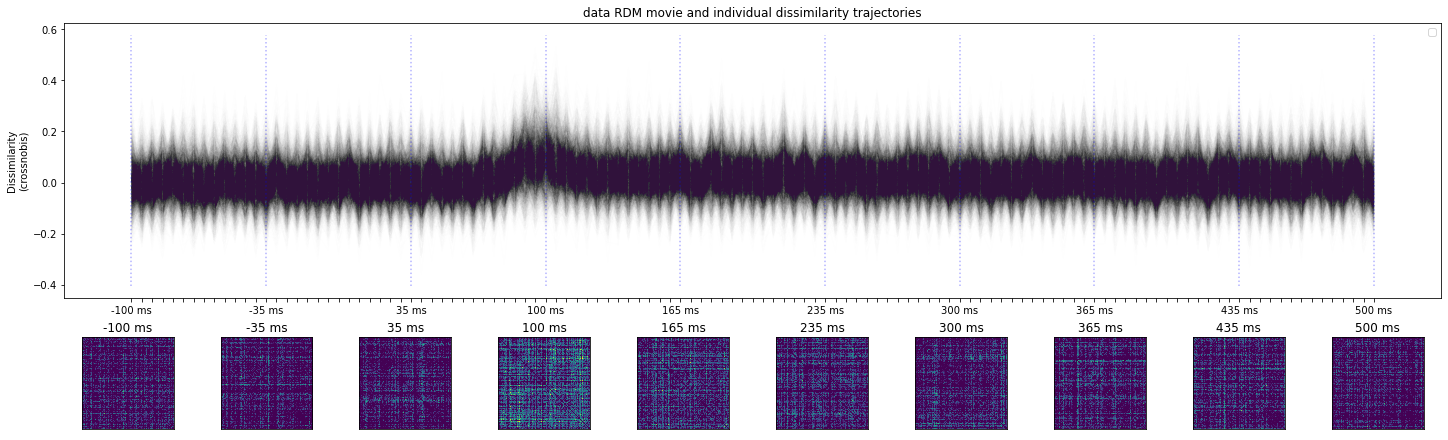

In [547]:
fig, ax = plot_rdm_movie(
                         rdms_data, 
                         descriptor, 
                         n_t_display=10, 
                         fig_width=20,
                         colored_conditions=None,
                        );
ax[0].set_title('data RDM movie and individual dissimilarity trajectories')

Text(0.5, 1.0, 'data RDM movie, dissimilarity trajectories grouped by face/not-face')

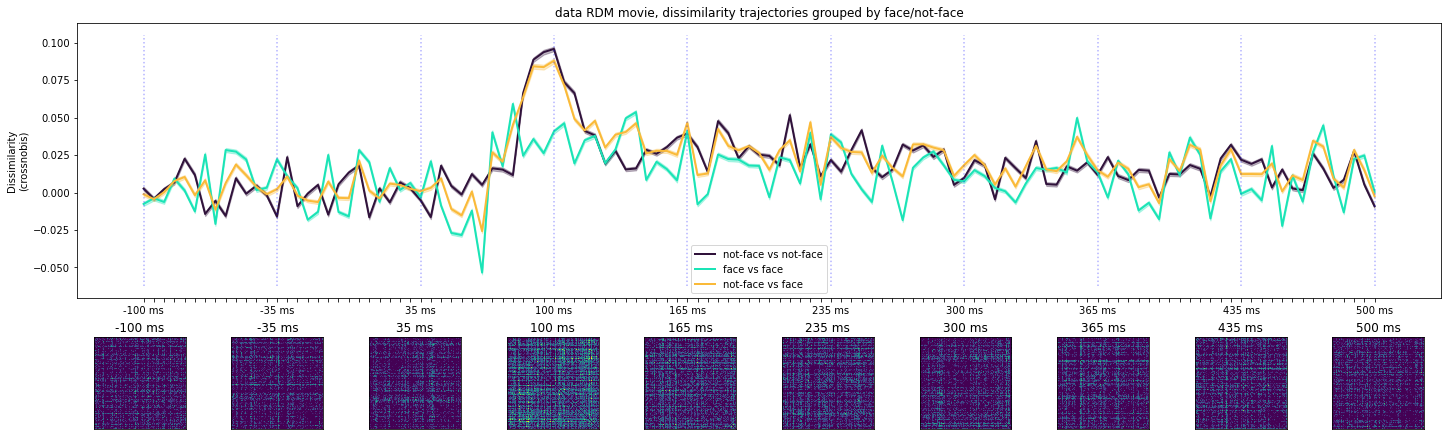

In [548]:
face = np.array([event_name.split('/')[3] for event_name in conditions])
fig, ax = plot_rdm_movie(
                         rdms_data, 
                         descriptor, 
                         n_t_display=10, 
                         fig_width=20,
                         colored_conditions=face
                        );
ax[0].set_title('data RDM movie, dissimilarity trajectories grouped by face/not-face')

Text(0.5, 1.0, 'data RDM movie, dissimilarity trajectories grouped by natural/non-natural')

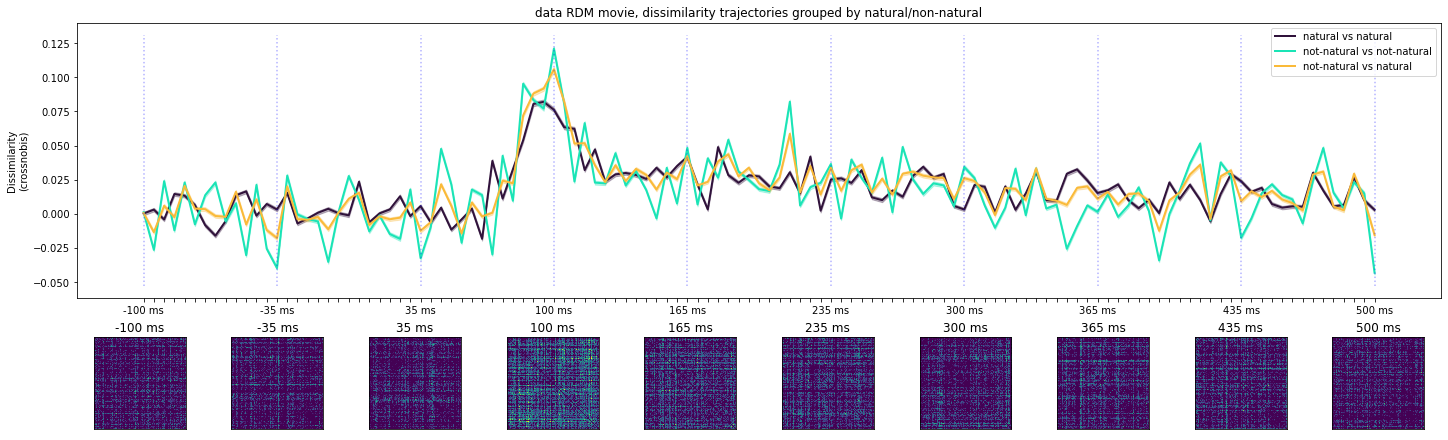

In [549]:
natural = np.array([event_name.split('/')[5] for event_name in conditions])
fig, ax = plot_rdm_movie(
                         rdms_data, 
                         descriptor, 
                         n_t_display=10, 
                         fig_width=20,
                         colored_conditions=natural
                        );
ax[0].set_title('data RDM movie, dissimilarity trajectories grouped by natural/non-natural')

## 4) evaluate RDM movie similarity to model RDMs

### define candidate model RDMs

In [318]:
image_index = np.array([int(event_name.split('/')[0]) for event_name in conditions])
condition = np.array([event_name.split('/')[1] for event_name in conditions])
human = np.array([event_name.split('/')[2] for event_name in conditions])
face = np.array([event_name.split('/')[3] for event_name in conditions])
animal = np.array([event_name.split('/')[4] for event_name in conditions])
natural = np.array([event_name.split('/')[5] for event_name in conditions])

For this example, we'll just look at two RDMs.
- A categorical RDM that encodes face-ness
- A categorical RDM that encodes natural-ness

In [319]:
face_notface_rdm = rsatoolbox.rdm.get_categorical_rdm([1 if i=='face' else 0 for i in face], 'face_notface')
face_notface_model = rsatoolbox.model.ModelFixed('face_notface', face_notface_rdm)

natural_notnatural_rdm = rsatoolbox.rdm.get_categorical_rdm([1 if i=='natural' else 0 for i in natural], 'natural_notnatural')
natural_notnatural_model = rsatoolbox.model.ModelFixed('natural_notnatural', natural_notnatural_rdm)

let's display the two model RDMs

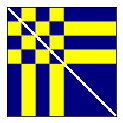

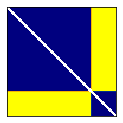

In [320]:
rsatoolbox.vis.show_rdm(face_notface_rdm);
rsatoolbox.vis.show_rdm(natural_notnatural_rdm);

In [321]:
model_names = ['face_notface', 'natural_notnatural']
models = [face_notface_model, natural_notnatural_model]

We chose cosine similarity for the crossnobis-RDMs

In [473]:
results = rsatoolbox.inference.eval_fixed(models, rdms_data, method='cosine')
print(f'{results.evaluations.shape=} = (n_bootstrap_samples, n_models, n_timepoints * n_subjects)')

results.evaluations.shape=(1, 2, 847) = (n_bootstrap_samples, n_models, n_timepoints * n_subjects)


## 5) compute cluster-based permutation statistic


timepoints and subjects are packed into the last dimension of results.evaluations

the util function num_index together with the rdm_descriptors from the rdms_data will help us indexing the correct elements

In [482]:
from rsatoolbox.util.descriptor_utils import num_index
print(f'{rdms_data.rdm_descriptors.keys() = }')

# get indices for the first timepoint in the last dimension of results.evaluations
print(f'\n{num_index(rdms_data.rdm_descriptors["time"], times[0]) = }')

# we reshape the evaluations to get a (n_models, n_subjects, n_timepoints) array
evaluations_reshaped = np.concatenate([results.evaluations[0][:, num_index(rdms_data.rdm_descriptors['time'], time)][:, :, np.newaxis] for time in np.unique(times)], axis=2)
print(f'\n{evaluations_reshaped.shape = }')

rdms_data.rdm_descriptors.keys() = dict_keys(['session', 'subject', 'index', 'time'])

num_index(rdms_data.rdm_descriptors["time"], times[0]) = array([  0, 121, 242, 363, 484, 605, 726], dtype=int64)

evaluations_reshaped.shape = (2, 7, 121)


evaluations_mean.shape=(2, 121)
evaluations_sem.shape=(2, 121)


Text(0.5, 0, 'time')

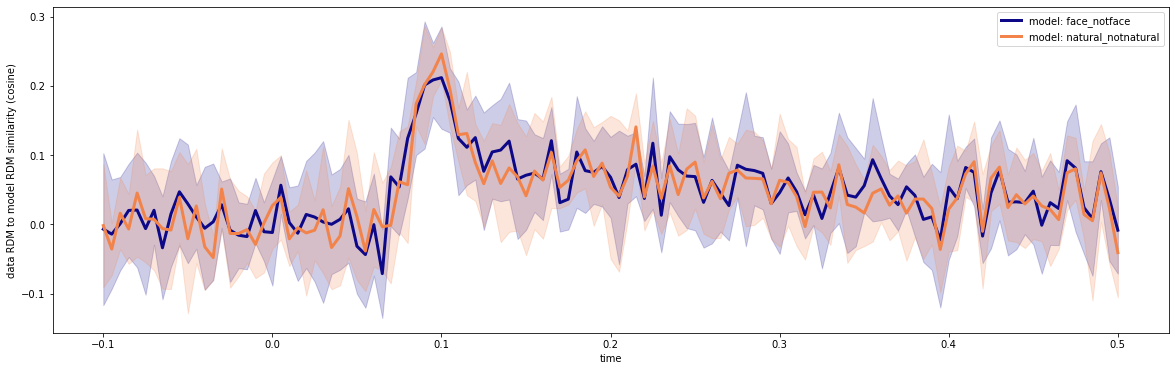

In [492]:
# mean and sem across subjects
evaluations_mean = np.mean(evaluations_reshaped, axis=1).squeeze()
evaluations_sem = np.std(evaluations_reshaped, axis=1).squeeze()

print(f'{evaluations_mean.shape=}')
print(f'{evaluations_sem.shape=}')

fig, ax = plt.subplots(1,1, figsize=(20,6))
colors = plt.get_cmap('plasma')(np.linspace(0., .7, len(model_names)))
for i, (ev,sem) in enumerate(zip(evaluations_mean, evaluations_sem)):
    ax.fill_between(np.unique(times), ev-sem, ev+sem, color=colors[i], alpha=.2)
    ax.plot(np.unique(times), ev, color=colors[i], label=f"model: {model_names[i]}", linewidth=3)
ax.legend();
ax.set_ylabel('data RDM to model RDM similarity (cosine)')
ax.set_xlabel('time')

In [521]:
def plot_contrast_stats(data, statistic, clusters, cluster_p_values, H0, model_names):
        
    T = np.unique(times)
    fig, (ax, ax2) = plt.subplots(2, 1, figsize=(8, 4))
    
    mn, se = data[0].mean(axis=0)-data[1].mean(axis=0), (data[0]-data[1]).std(axis=0) / np.sqrt(data.shape[0])
    ax.fill_between(T,mn-se,mn+se)
    ax.plot(T, mn, 
            label=f"{model_names[0]} vs {model_names[1]}")
        
    ax.set_ylabel("difference in data-model similarity")
    ax.legend()
    
    h = None
    for i_c, c in enumerate(clusters):
        c = c[0]
        if cluster_p_values[i_c] <= 0.05:            
            h = ax2.axvspan(T[c[0]], T[c[-1]],
                            color='r', alpha=0.3)
    ax1.plot(T, p_values, color='k')
    hf = plt.plot(T, F_obs, 'g')
    if h is not None:
        ax2.legend((h, ), ('cluster p-value < 0.05', ))
    ax2.set_xlabel("time")
    ax2.set_ylabel("f-values")
    
    return fig, (ax, ax2)
    
def plot_condition_stats(data, statistic, clusters, cluster_p_values, H0, model_name, axes=None):
        
    T = np.unique(times)
    if axes is None:
        fig, (ax, ax2) = plt.subplots(2, 1, figsize=(8, 4))
    else:
        ax, ax2 = axes
        fig = ax.get_figure()
    
    mn, se = data.mean(axis=0), data.std(axis=0) / np.sqrt(data.shape[0])
    ax.fill_between(T,mn-se,mn+se)
    ax.plot(T, mn, label=f"{model_name}")
    ax.set_ylabel("data-model similarity")
    ax.legend()
    
    h = None
    for i_c, c in enumerate(clusters):
        c = c[0]
        if cluster_p_values[i_c] <= 0.05:            
            h = ax2.axvspan(T[c[0]], T[c[-1]],
                            color='r', alpha=0.3)
    ax2.plot(T, F_obs, 'g')
    if h is not None:
        ax2.legend((h, ), ('cluster p-value < 0.05', ))
    ax2.set_xlabel("time")
    ax2.set_ylabel("f-values")    
    return fig, (ax, ax2)

stat_fun(H1): min=0.000071 max=3.897200
Running initial clustering
Found 25 clusters
Permuting 1023 times...


  0%|          |  : 0/1023 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


Text(0.5, 1.0, 'face_notface vs natural_notnatural')

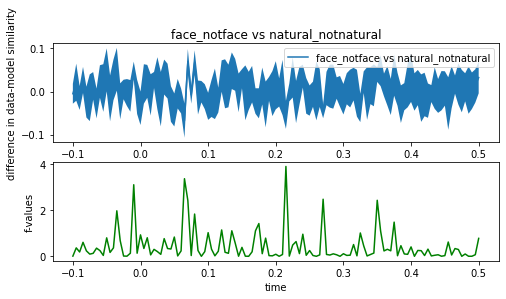

In [525]:
F_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(evaluations_reshaped, threshold=.05)

fig, ax = plot_contrast_stats(evaluations_reshaped, F_obs, clusters, cluster_p_values, H0, model_names)
ax[0].set_title(f'{model_names[0]} vs {model_names[1]}')

stat_fun(H1): min=-2.723173 max=9.531874
Running initial clustering
Found 24 clusters
Permuting 63 times (exact test)...


  0%|          |  : 0/63 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
stat_fun(H1): min=-3.636269 max=15.928653
Running initial clustering
Found 27 clusters
Permuting 63 times (exact test)...


  0%|          |  : 0/63 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


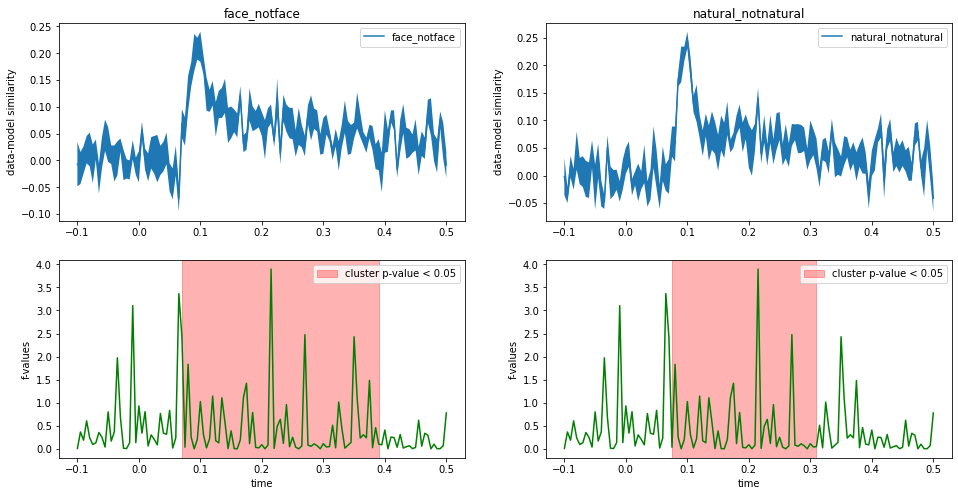

In [524]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

for model_name, data, ax in zip(model_names, evaluations_reshaped, axes.T):
    T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_1samp_test(data, threshold=.05)
    plot_condition_stats(data, T_obs, clusters, cluster_p_values, H0, model_name, axes=ax)
    ax[0].set_title(model_name)